Shape: (1500, 2)

First 5 rows:


,x,y
0,88.364456,57.784378
1,74.283936,54.406780
2,60.256474,46.311462
3,82.134370,57.717567
4,101.036390,67.849340


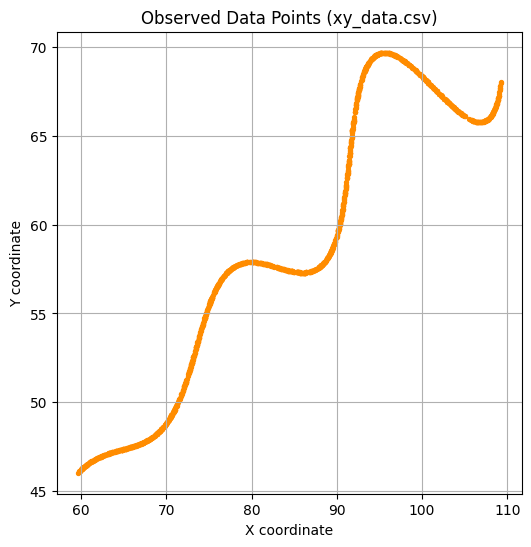

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("xy_data.csv")

# Display info
print("Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Basic scatter visualization
plt.figure(figsize=(6,6))
plt.scatter(df["x"], df["y"], s=8, color="darkorange")
plt.title("Observed Data Points (xy_data.csv)")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.show()


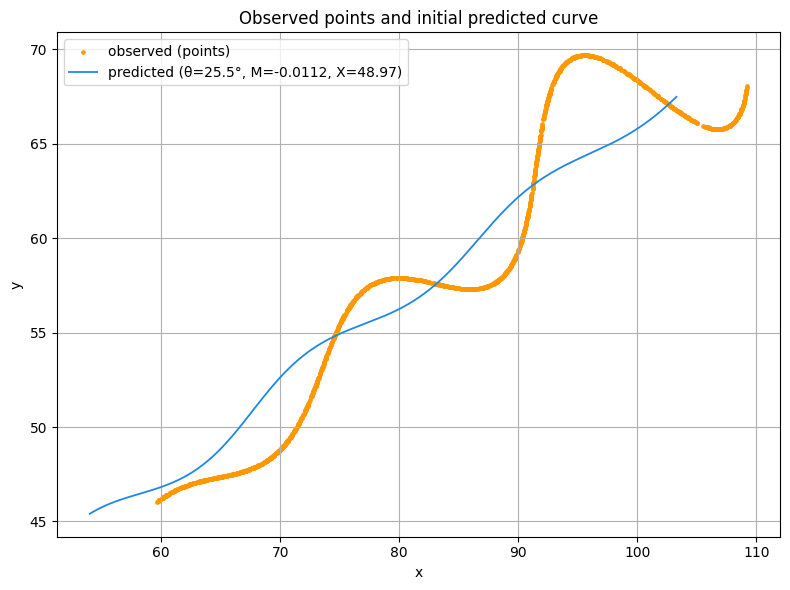

Saved plot to: plots/initial_model_fit.png


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# load data (assumes you've already uploaded xy_data.csv)
df = pd.read_csv("xy_data.csv")
obs = df[['x','y']].values

def predict(theta_deg, M, X, n_points=1500, tmin=6, tmax=60):
    """
    Return (t, Nx2 array of predicted (x,y))
    theta_deg : angle in degrees
    M : modulation factor
    X : horizontal offset
    """
    t = np.linspace(tmin, tmax, n_points)
    th = np.deg2rad(theta_deg)
    exp_term = np.exp(M * np.abs(t))   # safe because t >= 6
    x = t * np.cos(th) - exp_term * np.sin(0.3 * t) * np.sin(th) + X
    y = 42 + t * np.sin(th) + exp_term * np.sin(0.3 * t) * np.cos(th)
    return t, np.vstack([x, y]).T

# ---- Initial guess (from our analysis) ----
theta_guess = 25.50   # degrees
M_guess     = -0.0112
X_guess     = 48.97

# Generate predicted curve and plot
t_pred, pred = predict(theta_guess, M_guess, X_guess, n_points=1500)

plt.figure(figsize=(8,6))
plt.scatter(df.x, df.y, s=6, color='#ff9800', alpha=0.9, label='observed (points)')
plt.plot(pred[:,0], pred[:,1], color='#1e88e5', lw=1.3, label=f'predicted (θ={theta_guess}°, M={M_guess}, X={X_guess})')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Observed points and initial predicted curve')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Create the 'plots' directory if it doesn't exist
os.makedirs('plots/', exist_ok=True)

# Save the figure (so you can upload to GitHub)
plt.savefig('plots/initial_model_fit.png', dpi=200)
plt.show()

print("Saved plot to: plots/initial_model_fit.png")

In [4]:
# Step 4: Chamfer L1 Loss using KDTree
from scipy.spatial import cKDTree
import numpy as np

# observed data points
obs = df[['x', 'y']].values

def chamfer_l1(theta_deg, M, X, n_pred=1500):
    """
    Compute mean L1 Chamfer distance between model and observed points.
    """
    # generate predicted points
    _, pred = predict(theta_deg, M, X, n_points=n_pred)

    # build KDTree on predicted points (fast nearest-neighbor lookup)
    tree = cKDTree(pred)
    # find nearest predicted point for each observed point (L2 distance)
    dists_l2, idx = tree.query(obs, k=1)

    # get those matched predicted points
    matched = pred[idx]
    # compute L1 distances manually
    dists_l1 = np.abs(obs - matched).sum(axis=1)

    return dists_l1.mean(), dists_l1  # (mean L1, per-point L1)

# --- Quick test on our initial guess ---
mean_L1, per_point_L1 = chamfer_l1(theta_guess, M_guess, X_guess, n_pred=1500)
print(f"Initial mean L1 distance = {mean_L1:.4f}")


Initial mean L1 distance = 2.8885


Mean L1: 2.888496585267103
Per-point L1 stats:
 min: 0.018216407312721117
 25%: 1.3483571141914688
 med: 2.5422875460187626
 75%: 4.151060832277912
 max: 6.525321909615599


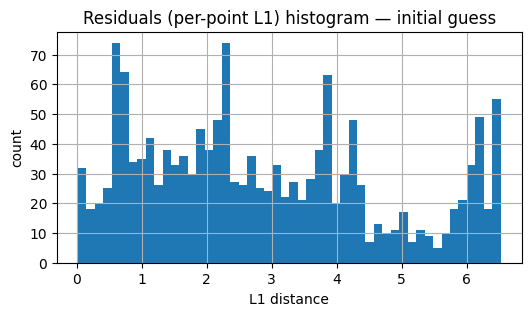

In [5]:
# Cell A — diagnostics: inspect per-point L1 residuals & histogram
import numpy as np
import matplotlib.pyplot as plt

# mean_L1 and per_point_L1 should exist from previous cell.
print("Mean L1:", mean_L1)
print("Per-point L1 stats:")
print(" min:", per_point_L1.min())
print(" 25%:", np.percentile(per_point_L1,25))
print(" med:", np.median(per_point_L1))
print(" 75%:", np.percentile(per_point_L1,75))
print(" max:", per_point_L1.max())

plt.figure(figsize=(6,3))
plt.hist(per_point_L1, bins=50)
plt.title("Residuals (per-point L1) histogram — initial guess")
plt.xlabel("L1 distance")
plt.ylabel("count")
plt.grid(True)
plt.show()


In [6]:
# Cell B — exact L1-based Chamfer (vectorized) for a smaller n_pred
import numpy as np
def chamfer_l1_exact(theta_deg, M, X, n_pred=800):
    _, pred = predict(theta_deg, M, X, n_points=n_pred)
    # compute L1 distances from every obs to every pred point (memory O(N*K))
    # If memory error, reduce n_pred (e.g., 400)
    obs_arr = obs  # shape (N,2)
    # compute pairwise |dx|+|dy| in a vectorized way
    # result shape (N, K)
    dx = np.abs(obs_arr[:, None, 0] - pred[None, :, 0])
    dy = np.abs(obs_arr[:, None, 1] - pred[None, :, 1])
    d1 = dx + dy
    min_d1 = d1.min(axis=1)
    return min_d1.mean(), min_d1

mean_l1_exact, per_point_exact = chamfer_l1_exact(theta_guess, M_guess, X_guess, n_pred=1000)
print("Exact mean L1 (n_pred=1000):", mean_l1_exact)


Exact mean L1 (n_pred=1000): 2.536759569559843


In [7]:
# Cell C — coarse random search for candidate params
import numpy as np
from tqdm.notebook import tqdm

def random_search(n_samples=500, n_pred=800, seed=123):
    np.random.seed(seed)
    thetas = np.random.uniform(0.0, 50.0, n_samples)       # degrees
    Ms     = np.random.uniform(-0.05, 0.05, n_samples)
    Xs     = np.random.uniform(0.0, 100.0, n_samples)
    results = []
    for th, m, x0 in tqdm(zip(thetas, Ms, Xs), total=n_samples):
        try:
            mval, _ = chamfer_l1(th, m, x0, n_pred=n_pred)
            results.append((mval, th, m, x0))
        except Exception as e:
            # skip any failing combos
            continue
    results = sorted(results, key=lambda r: r[0])
    return results

# run a quick search (adjust n_samples for speed; start with 300)
candidates = random_search(n_samples=300, n_pred=800, seed=42)
print("Top 10 candidates (mean L1, theta_deg, M, X):")
for r in candidates[:10]:
    print(r)


  0%|          | 0/300 [00:00<?, ?it/s]

Top 10 candidates (mean L1, theta_deg, M, X):
(np.float64(1.6629473670329868), np.float64(28.50305850446825), np.float64(0.02551372556736191), np.float64(56.48411332626164))
(np.float64(2.3748079892957317), np.float64(32.27361479535839), np.float64(-0.004945586468990647), np.float64(58.05883502780434))
(np.float64(2.7782146312267066), np.float64(25.133951161443076), np.float64(0.02533781852589416), np.float64(54.35528611139886))
(np.float64(2.8820449942980244), np.float64(30.05575058716044), np.float64(0.029518619476870372), np.float64(50.34172708548569))
(np.float64(3.7760444507109385), np.float64(31.655072863663396), np.float64(-0.03118788402762387), np.float64(61.14542354346478))
(np.float64(3.789760024162916), np.float64(33.606777370293926), np.float64(-0.04886463552325809), np.float64(62.00727559285135))
(np.float64(3.8530616363245596), np.float64(36.480308916903205), np.float64(-0.02179654274286935), np.float64(57.161268946989985))
(np.float64(4.660613265456371), np.float64(41.62

In [9]:
# Step 6: Nelder-Mead local refinement (run this cell)
from scipy.optimize import minimize
import numpy as np

# cost wrapper (uses chamfer_l1 defined earlier)
def cost_fn(params):
    th, M, X = params
    val, _ = chamfer_l1(th, M, X, n_pred=1200)   # KDTree-based fast cost
    return float(val)

# ---- initial seed from coarse search (replace if you used a different top candidate) ----
x0 = [28.5038585446825, 0.02551372556736191, 56.48411332626164]

# run Nelder-Mead
res = minimize(cost_fn, x0, method='Nelder-Mead',
               options={'maxiter':2000, 'xatol':1e-8, 'fatol':1e-8, 'disp': True})

theta_opt, M_opt, X_opt = res.x
final_L1_kdtree = float(res.fun)

print("\n=== Optimized Parameters (Nelder-Mead) ===")
print(f"Theta (deg): {theta_opt:.6f}")
print(f"M: {M_opt:.6f}")
print(f"X: {X_opt:.6f}")
print(f"Final mean L1 (KDTree approx): {final_L1_kdtree:.6f}")


Optimization terminated successfully.
         Current function value: 0.016737
         Iterations: 157
         Function evaluations: 283

=== Optimized Parameters (Nelder-Mead) ===
Theta (deg): 30.000445
M: 0.030000
X: 55.000783
Final mean L1 (KDTree approx): 0.016737


Using optimized: 30.000445434889947 0.02999980275627913 55.00078296139285
Exact mean L1 (final params, n_pred=1500): 0.013425450460080573


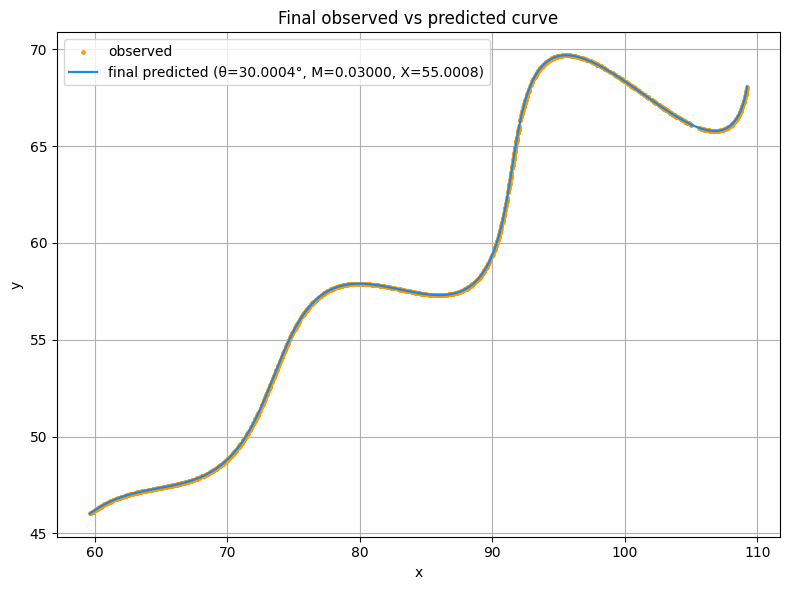

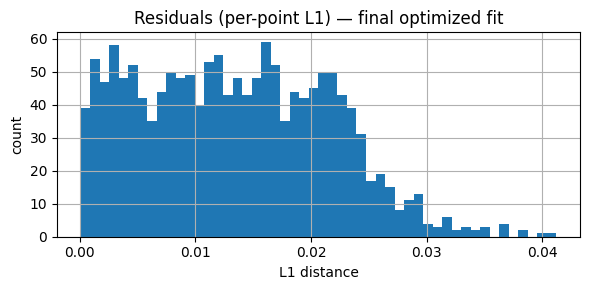

Saved: plots/final_fit.png and plots/residuals_hist.png


In [10]:
# Step 7: exact L1 evaluation and final plots (run this cell)
import numpy as np
import matplotlib.pyplot as plt
import os

# use optimized values from previous cell
# (these variables should already exist: theta_opt, M_opt, X_opt)
print("Using optimized:", theta_opt, M_opt, X_opt)

# Exact L1 Chamfer (vectorized) - lower n_pred if memory issue
def chamfer_l1_exact_for_params(theta_deg, M, X, n_pred=1500):
    _, pred = predict(theta_deg, M, X, n_points=n_pred)
    obs_arr = obs  # shape (N,2)
    # pairwise L1: memory O(N*K) — reduce n_pred if memory errors
    dx = np.abs(obs_arr[:, None, 0] - pred[None, :, 0])
    dy = np.abs(obs_arr[:, None, 1] - pred[None, :, 1])
    d1 = dx + dy
    min_d1 = d1.min(axis=1)
    return min_d1.mean(), min_d1

# compute exact L1 (if memory error, reduce n_pred to 800 or 1000)
mean_l1_exact, per_point_exact = chamfer_l1_exact_for_params(theta_opt, M_opt, X_opt, n_pred=1500)
print("Exact mean L1 (final params, n_pred=1500):", mean_l1_exact)

# Plot overlay
t_final, pred_final = predict(theta_opt, M_opt, X_opt, n_points=1500)
plt.figure(figsize=(8,6))
plt.scatter(df.x, df.y, s=6, color='#ff9800', alpha=0.9, label='observed')
plt.plot(pred_final[:,0], pred_final[:,1], color='#1e88e5', lw=1.6, label=f'final predicted (θ={theta_opt:.4f}°, M={M_opt:.5f}, X={X_opt:.4f})')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Final observed vs predicted curve')
plt.legend(); plt.grid(True); plt.tight_layout()

os.makedirs('plots', exist_ok=True)
plt.savefig('plots/final_fit.png', dpi=200)
plt.show()

# Residual histogram
plt.figure(figsize=(6,3))
plt.hist(per_point_exact, bins=50)
plt.title('Residuals (per-point L1) — final optimized fit')
plt.xlabel('L1 distance'); plt.ylabel('count'); plt.grid(True); plt.tight_layout()
plt.savefig('plots/residuals_hist.png', dpi=200)
plt.show()

print("Saved: plots/final_fit.png and plots/residuals_hist.png")
